In [2]:
from __future__ import annotations
from pathlib import Path
from s7.models import create_config
from s7.xlsparser import XLSParser
from s7.classgen import class_factory

# Import Configuration
xls_config = create_config(Path(".").resolve() / 'inhibitor_conf.yml')

# Generate Specific Parser from config
parser = XLSParser(xls_config)
v = parser.get()
print(v)

# Generate entity (not a S7-model yet...)
XLSData = class_factory("XLSData", v)

x = XLSData()
x.inhibitorEfficiency


{'sampleType': ['LiCO3', 'LiCO3', 'LiCl', 'LiCl', 'LiCl'], 'casNumber': ['554-13-2', '554-13-2', '7447-41-8', '7447-41-8', '7447-41-8'], 'runID': ['27082021_1mMLiCO3_0.1MNaCl_AA2024_run4', '27082021_1mMLiCO3_0.1MNaCl_AA2024_run5', '11082021_1mMLiCl_0.1MNaCl_AA2024_run1', '11082021_1mMLiCl_0.1MNaCl_AA2024_run2', '11082021_1mMLiCl_0.1MNaCl_AA2024_run3'], 'inhibitorEfficiency': [82.84807910472972, 82.70578220798093, -32.10177835991128, 0.7790838781530862, 31.69712512083033], 'impedance_log_24h': [5.00314131824638, 4.99955315940226, 4.11654541915057, 4.24085085066989, 4.40301509970376], 'impedance_ohm_24h': [100725.93749999841, 99897.1640624986, 13078.123046874862, 17412.08789062481, 25293.859374999603], 'impedance_kohm_24h': [79.06986093749876, 78.4192737890614, 10.266326591796767, 13.668488994140477, 19.85567960937469]}


[82.84807910472972,
 82.70578220798093,
 -32.10177835991128,
 0.7790838781530862,
 31.69712512083033]

In [1]:
from pathlib import Path
# from s7.entitygen import create_entity
from s7.entitygen_simple import create_entity
from s7.models import create_config

xls_config = create_config(Path(".").resolve() / 'inhibitor_conf.yml')

DataSourceEntity = create_entity(
    data_model=Path(".").resolve() / "efficiency.yaml",
    resource_config={
        "downloadUrl": (Path(".").resolve() / "Inhibitor_Data_Analysis_summary.xlsx").as_uri(),
        "mediaType": "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",
        "configuration": xls_config,
    },
)
entity = DataSourceEntity()
print(entity.casNumber)
entity.schema()

# function_mapping = {
#     # Specific doubles, based on graph traversal back to inner entity's inhibitorEfficiency - through a generic "doubles" function: f(x)=2*x
#     "doubles": lambda: [_ * 2 for _ in entity.inhibitorEfficiency],
# }

# lambda prop: getattr(entity, prop, None)

['554-13-2', '554-13-2', '7447-41-8', '7447-41-8', '7447-41-8']


{'title': 'DataSourceEntity',
 'description': 'Generic Data source entity',
 'type': 'object',
 'properties': {'sampleType': {'title': 'sampleType',
   'description': 'Molecule name',
   'type': 'string'},
  'casNumber': {'title': 'casNumber',
   'description': 'CAS number',
   'type': 'string'},
  'runID': {'title': 'runID',
   'description': 'Experiment identification',
   'type': 'string'},
  'inhibitorEfficiency': {'title': 'inhibitorEfficiency',
   'description': 'EIS 24h',
   'type': 'number'},
  'impedance_log_24h': {'title': 'impedance_log_24h',
   'description': 'Impedance Log (24h)',
   'type': 'number'},
  'impedance_ohm_24h': {'title': 'impedance_ohm_24h',
   'description': 'Impedance Ohm (24h)',
   'type': 'number'},
  'impedance_kohm_24h': {'title': 'impedance_kohm_24h',
   'description': 'Impedance kOhm (24h)',
   'type': 'number'}},
 'additionalProperties': False}

In [3]:
from s7.graph import Graph

graph_mapping = [
    # ("properties.SMILES", "mapsTo", "SMILES"),
    # ("properties.inhibitorEfficiency", "mapsTo", "EISEfficiency"),
    # ("data.casNumber", "mapsTo", "CAS#"),
    # ("data.inhibitorEfficiency", "mapsTo", "ImpedanceOhm"),
    ("imp_to_flux", "expects", "ImpedanceOhm"),
    ("imp_to_flux", "outputs", "EISEfficiency"),
    ("imp_to_flux", "isA", "function"),
    ("ImpedanceOhm", "isA", "Resistance"),
    ("ImpedanceLogOhm", "isA", "Resistance"),
    ("EISEfficiency", "isA", "InhibitorEfficiency"),
    ("LPREfficiency", "isA", "InhibitorEfficiency"),
    ("Resistance", "isA", "Parameter"),
    ("InhibitorEfficiency", "isA", "Output"),
    # ("function", "hasMethod", "execute"),
    ("cas_to_smiles", "isA", "function"),
    ("cas_to_smiles", "expects", "CAS#"),
    ("cas_to_smiles", "outputs", "SMILES"),

    # Generated in `create_outer_entity()`:
    # ("imp_to_flux", "executes", lambda: ...)
    # ("cas_to_smiles", "executes", lambda: ...)
]
graph = Graph(graph_mapping)
graph.plot()
for _ in graph.recur_find("EISEfficiency", "ImpedanceOhm"):
    print(_)
# graph.path("SMILES", "CAS#")


['EISEfficiency', 'imp_to_flux', 'ImpedanceOhm']


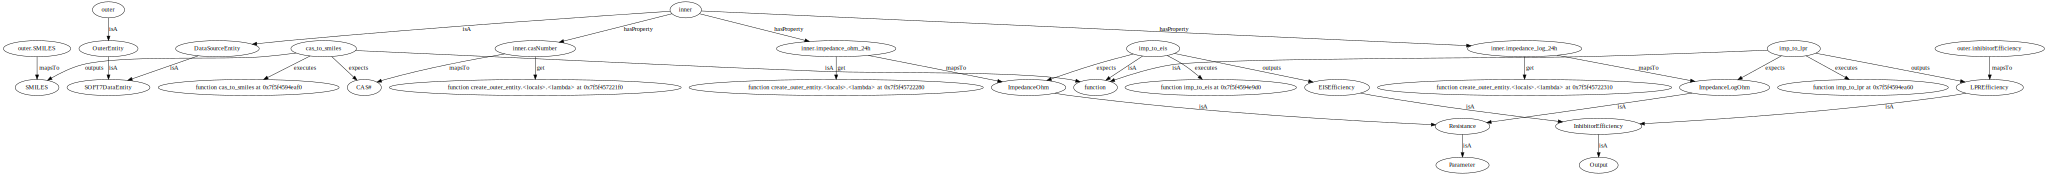

[['outer.inhibitorEfficiency', 'LPREfficiency', 'imp_to_lpr', 'ImpedanceLogOhm', 'inner.impedance_log_24h', 'inner']]
['imp_to_lpr']
['ImpedanceLogOhm']
['inner.impedance_log_24h']
[2.50157065912319, 2.49977657970113, 2.058272709575285, 2.120425425334945, 2.20150754985188]
[201451.87499999683, 199794.3281249972, 26156.246093749724, 34824.17578124962, 50587.71874999921]
[2.50157065912319, 2.49977657970113, 2.058272709575285, 2.120425425334945, 2.20150754985188]
[['outer.SMILES', 'SMILES', 'cas_to_smiles', 'CAS#', 'inner.casNumber', 'inner']]
['cas_to_smiles']
['CAS#']
['inner.casNumber']
['[Li+].[Li+].[O-]C([O-])=O', '[Li+].[Li+].[O-]C([O-])=O', '[Li+].[Cl-]', '[Li+].[Cl-]', '[Li+].[Cl-]']
['554-13-2', '554-13-2', '7447-41-8', '7447-41-8', '7447-41-8']


{'title': 'OuterEntity',
 'description': 'Generic Data source entity',
 'type': 'object',
 'properties': {'SMILES': {'title': 'SMILES',
   'description': 'SMILES',
   'type': 'string'},
  'inhibitorEfficiency': {'title': 'inhibitorEfficiency',
   'description': 'EIS 24h',
   'type': 'number'}},
 'additionalProperties': False}

In [2]:
from s7.outer_entitygen_simple import create_outer_entity

GetEfficiency = create_outer_entity(
    data_model=Path(".").resolve() / "ai_model.yaml",
    inner_entity=entity,
    mapping=[
        ("outer.SMILES", "mapsTo", "SMILES"),
        ("outer.inhibitorEfficiency", "mapsTo", "LPREfficiency"),
        ("inner.casNumber", "mapsTo", "CAS#"),
        ("inner.impedance_ohm_24h", "mapsTo", "ImpedanceOhm"),
        ("inner.impedance_log_24h", "mapsTo", "ImpedanceLogOhm"),
    ],
)
outer_entity = GetEfficiency()
print(outer_entity.inhibitorEfficiency)
print([_ * 2 for _ in entity.impedance_ohm_24h])
print([_ / 2 for _ in entity.impedance_log_24h])
print(outer_entity.SMILES)
print(entity.casNumber)
outer_entity.schema()


In [4]:
from s7.graph import Graph
g = Graph()
d = XLSData()

print (d.sampleType)

g.append(('entity', 'hasProperty', 'entity:sampleType'))
g.append(('entity:sampleType', 'propertyOf', 'entity'))

g.append(('entity', 'hasProperty', 'entity:casNumber'))
g.append(('entity:casNumber', 'propertyOf', 'entity'))

g.append(('entity:sampleType', 'mapsTo', 'ontology:sampleType'))
g.append(('entity:sampleType', 'propertyOf', 'entity'))

g.append(('ontology:sampleType', 'mapsfrom', 'entity:sampleType'))
g.append(('entity:casNumber', 'mapsTo', 'ontology:casNumber'))
g.append(('ontology:casNumber', 'mapsFrom', 'entity:casNumber'))
g.append(('entity:inhibitorEfficiency', 'mapsTo', 'ontology:inhibitorEfficiency'))
g.append(('ontology:inhibitorEfficiency', 'mapsTo', 'entity:inhibitorEfficiency'))

g.append(((lambda : d.sampleType), 'executes', 'entity:sampleType'))
g.append(((lambda : d.casNumber), 'executes', 'entity:casNumber'))
g.append(((lambda : d.inhibitorEfficiency), 'executes', 'entity:inhibitorEfficiency'))

# consumer mapping
g.append(('consumer:eff', 'mapsTo', 'ontology:inhibitorEfficiency'))
g.append(('consumer:cas', 'mapsTo', 'ontology:casNumber'))


NameError: name 'XLSData' is not defined

In [ ]:
import math
math.pow(10, x.impedance[0])